## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
idx_to_token = dict(enumerate(tokens))

# dict <char>:<index>
# Your great code here
token_to_idx = {token : idx for idx, token in idx_to_token.items()}

In [6]:
print(idx_to_token)

{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z'}


In [7]:
print(token_to_idx)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
def one_hot_encode(data, number_of_labels):
    assert len(data.shape) == 2, "Dimension of data to encode should be 2D!"
    total_to_encode = data.shape[0] * data.shape[1]
    one_hot_encoded = torch.zeros(total_to_encode, number_of_labels)
    one_hot_encoded[torch.arange(total_to_encode), data.flatten()] = 1
    return one_hot_encoded.reshape((*data.shape, number_of_labels))

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
# Your code here

import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn import Parameter

In [10]:
num_tokens = len(tokens)
print(num_tokens)

38


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class VanillaRNN(nn.Module):
    def __init__(self, n_tokens, n_hidden=512, n_layers=1):
        super(self.__class__, self).__init__()
        self.n_tokens = n_tokens
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.rnn = nn.RNN(self.n_tokens, self.n_hidden, self.n_layers, batch_first=True)
        self.lin = nn.Linear(self.n_hidden, self.n_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.reshape(-1, self.n_hidden)
        out = self.lin(out)
        return out, hidden
        
    def init_hidden(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)

In [13]:
def get_batches(data, batch_size, sequence_length):
    batch_size_total = batch_size * sequence_length
    number_batches = len(data) // batch_size_total
    data = data[:number_batches * batch_size_total]
    data = data.reshape((batch_size, -1))
    for n in range(0, data.shape[1], sequence_length):
        x = data[:, n:n+sequence_length]
        y = torch.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], data[:, n+sequence_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], data[:, 0]
        yield x, y

In [14]:
def train(model, data, optimizer, criterion, epochs, batch_size, sequence_length):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        loss_value = []
        h = model.init_hidden(batch_size)
        for x, y in get_batches(data, batch_size, sequence_length):
            x = one_hot_encode(x, num_tokens)
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            h.detach_()  # no need to calculate gradient
            output, h = model.forward(x, h)
            loss = criterion(output, y.reshape(batch_size*sequence_length).long())
            loss_value.append(loss.item())
            loss.backward()
            optimizer.step()
        loss_history.append(sum(loss_value) / len(loss_value))
        print(f"Epoch: {epoch + 1}/{epochs}: Loss: {loss_history[-1]:.4f}:")
    return loss_history

In [15]:
n_hidden = 512
model = VanillaRNN(num_tokens, n_hidden).to(device)

batch_size = 128
sequence_length = 100
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

text_encoded = torch.tensor([token_to_idx[token] for token in text])

loss_list = train(model, text_encoded, optimizer, criterion, epochs, batch_size, sequence_length)

Epoch: 1/100: Loss: 3.2462:
Epoch: 2/100: Loss: 2.9636:
Epoch: 3/100: Loss: 2.9326:
Epoch: 4/100: Loss: 2.9035:
Epoch: 5/100: Loss: 2.8716:
Epoch: 6/100: Loss: 2.8248:
Epoch: 7/100: Loss: 2.7604:
Epoch: 8/100: Loss: 2.6866:
Epoch: 9/100: Loss: 2.7597:
Epoch: 10/100: Loss: 2.6560:
Epoch: 11/100: Loss: 2.5866:
Epoch: 12/100: Loss: 2.5213:
Epoch: 13/100: Loss: 2.4608:
Epoch: 14/100: Loss: 2.4322:
Epoch: 15/100: Loss: 2.3877:
Epoch: 16/100: Loss: 2.3398:
Epoch: 17/100: Loss: 2.3045:
Epoch: 18/100: Loss: 2.2749:
Epoch: 19/100: Loss: 2.2410:
Epoch: 20/100: Loss: 2.2131:
Epoch: 21/100: Loss: 2.1939:
Epoch: 22/100: Loss: 2.1711:
Epoch: 23/100: Loss: 2.1692:
Epoch: 24/100: Loss: 2.1794:
Epoch: 25/100: Loss: 2.1707:
Epoch: 26/100: Loss: 2.1357:
Epoch: 27/100: Loss: 2.1165:
Epoch: 28/100: Loss: 2.0995:
Epoch: 29/100: Loss: 2.0850:
Epoch: 30/100: Loss: 2.0733:
Epoch: 31/100: Loss: 2.0642:
Epoch: 32/100: Loss: 2.0556:
Epoch: 33/100: Loss: 2.0472:
Epoch: 34/100: Loss: 2.0410:
Epoch: 35/100: Loss: 2.

Plot the loss function (axis X: number of epochs, axis Y: loss function).

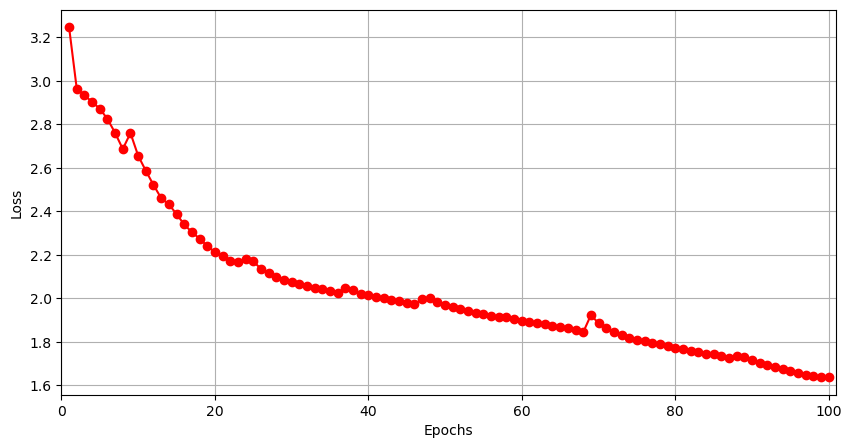

In [16]:
# Your plot code here
import matplotlib.pyplot as plt

epochs_list = list(range(1, epochs + 1))
fig = plt.figure(figsize=(10,5))
ax = fig.subplots()
ax.plot(epochs_list, loss_list, 'r', marker='o')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xlim([0, epochs + 1])
ax.grid()
plt.show()

In [17]:
def sample(model, size, prime=' hello', temperature=1.0):
    
    def predict(model, char, h=None):
        x = np.array([[token_to_idx[char]]])
        x = one_hot_encode(x, model.n_tokens)
        inputs = x.to(device)
        out, h = model(inputs, h)
        p = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p)
        return idx_to_token[next_ix], h

    model.eval()
    chars = [ch for ch in prime]
    h = model.init_hidden(batch_size=1)
    for ch in prime:
        char, h = predict(model, ch, h=h)
    chars.append(char)
    for ii in range(size):
        char, h = predict(model, chars[-1], h=h)
        chars.append(char)

    return ''.join(chars)

In [18]:
print(sample(model, 500, ' hello', 0.2))

 hellove when i have the will with the will be the wirl will not the thee,
    and thee thou art the with urous and thee thee in the thee the bearty that in the eare shell my hame the fore the sender of me that that is the will be the seall the wind and mine eye some thee the romest thou hast thou the with thee the reall the sumber four dear all the stoll the wist my love shall self it of thee in the rould my love thou hast thou hast thou hast thou art thee the pores in heart the world mo thee mo the w


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [19]:
# Your beautiful code here
class LSTM(nn.Module):
    
    def __init__(self, n_tokens, n_hidden=256, n_layers=1):
        super(self.__class__, self).__init__()
        self.n_tokens = n_tokens
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(self.n_tokens, self.n_hidden, self.n_layers, batch_first=True)
        self.lin = nn.Linear(self.n_hidden, self.n_tokens)
        
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out.reshape(-1, self.n_hidden)
        out = self.lin(out)
        return out, hidden
    
    def init_hidden(self, batch_size=1):
        hidden = (torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device),
                  torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device))
        return hidden

In [20]:
def train_lstm(model, data, optimizer, criterion, epochs, batch_size, sequence_length):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        loss_value = []
        h = model.init_hidden(batch_size)
        for x, y in get_batches(data, batch_size, sequence_length):
            x = one_hot_encode(x, num_tokens)
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            h[0].detach_(), h[1].detach_()  # no need to calculate gradient
            output, h = model.forward(x, h)
            loss = criterion(output, y.reshape(batch_size*sequence_length).long())
            loss_value.append(loss.item())
            loss.backward()
            optimizer.step()
        loss_history.append(sum(loss_value) / len(loss_value))
        print(f"Epoch: {epoch + 1}/{epochs}: Loss: {loss_history[-1]:.4f}:")
    return loss_history

In [21]:
# Text generation with different temperature values here
n_hidden = 512
model = LSTM(num_tokens, n_hidden).to(device)

batch_size = 128
sequence_length = 100
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

text_encoded = torch.tensor([token_to_idx[token] for token in text])

In [22]:
loss_list = train_lstm(model, text_encoded, optimizer, criterion, epochs, batch_size, sequence_length)

Epoch: 1/100: Loss: 3.4845:
Epoch: 2/100: Loss: 3.1943:
Epoch: 3/100: Loss: 2.9892:
Epoch: 4/100: Loss: 2.9658:
Epoch: 5/100: Loss: 2.9491:
Epoch: 6/100: Loss: 2.9437:
Epoch: 7/100: Loss: 2.9376:
Epoch: 8/100: Loss: 2.9322:
Epoch: 9/100: Loss: 2.9255:
Epoch: 10/100: Loss: 2.9169:
Epoch: 11/100: Loss: 2.9050:
Epoch: 12/100: Loss: 2.8869:
Epoch: 13/100: Loss: 2.8631:
Epoch: 14/100: Loss: 2.8244:
Epoch: 15/100: Loss: 2.7713:
Epoch: 16/100: Loss: 2.7098:
Epoch: 17/100: Loss: 2.6508:
Epoch: 18/100: Loss: 2.5971:
Epoch: 19/100: Loss: 2.5285:
Epoch: 20/100: Loss: 2.5406:
Epoch: 21/100: Loss: 2.4944:
Epoch: 22/100: Loss: 2.4438:
Epoch: 23/100: Loss: 2.3956:
Epoch: 24/100: Loss: 2.3589:
Epoch: 25/100: Loss: 2.3274:
Epoch: 26/100: Loss: 2.2966:
Epoch: 27/100: Loss: 2.2712:
Epoch: 28/100: Loss: 2.2498:
Epoch: 29/100: Loss: 2.2250:
Epoch: 30/100: Loss: 2.2081:
Epoch: 31/100: Loss: 2.1884:
Epoch: 32/100: Loss: 2.1835:
Epoch: 33/100: Loss: 2.1619:
Epoch: 34/100: Loss: 2.1479:
Epoch: 35/100: Loss: 2.

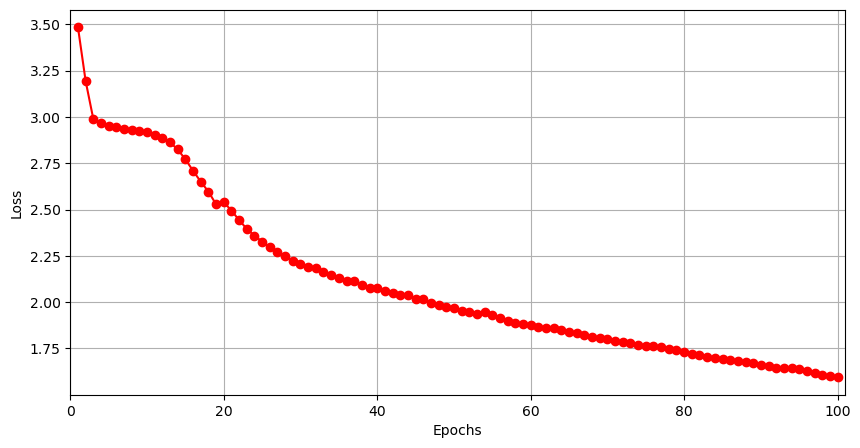

In [23]:
# Your plot code here
import matplotlib.pyplot as plt

epochs_list = list(range(1, epochs + 1))
fig = plt.figure(figsize=(10,5))
ax = fig.subplots()
ax.plot(epochs_list, loss_list, 'r', marker='o')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xlim([0, epochs + 1])
ax.grid()
plt.show()

We can observe that our model is able to achieve a lower loss than before with our simple RNN implementation. This should now also be reflected when we generate new samples. Note, that we increase the number of epochs the loss will decrease further.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

Now let's look at the effect of temperature. We'll start with a very low temperature:

In [24]:
print(sample(model, 1000, ' hello', 0.1))

 hellove the steen the store the store,
  and the east thou with the store the store thee,
  the store the stare the store the wind the steen,
  the stould the store the store the store thee,
  the sone the store the fare the cond and canse,
  and the east thou with the store the store thee,
  the stould the store the wind the seat store,
  and the store the will with the store to thee,
  and the east whe eres the store the store thee,
    the sead the praise the will with the store thee,
  the store the fair the store the live the seat,
  the store the will with the store the store,
  and the east thou make the store the store thee,
  when i the sore the with the elf at of me.

  xxxii

  thou art the stare the stare the store the stere,
  and the store the with the will the east the sweet,
  that thou art the store the store the store the stere,
  and the store the stare the store to the store,
  and the east my seate that thou art the store,
  the eart the will with the store the st

In [25]:
print(sample(model, 1000, ' hello', 0.2))

 hellong in the sweet white thou song and thee,
    and the east shall the wint of the will stome thee,
  the sone the fore the store the wind the stare,
  the sone the fair the will which i store thee,
  that the store that thou hast the store the will,
  which shall the store the store the store to thee,
  and the east of the with the sond and the thes,
  and thee the seef thou hast thou hours the seat,
  whe hast the store the fare the will for my love,
  the stould the stare the love the store thee thene,
  when i mast my the the with the eaven thee thee,
    the sand the wind the stare the fore thee stere,
  the steen the will the stare the store the will,
  the store the will with the stall the steen thee,
    the eaven the will where thou art thou art mend,
  and the east whe eres the store the store thee,
  the sone the stare the fare the love the frees,
  the store the will with the east mine of me thee,
    the sond the stere the stare the store thee these,
  when i the will 

In [26]:
print(sample(model, 1000, ' hello', 0.5))

 hellon some the ell-will i sulf and graee,
  and stoul the hald mo had the day his the whet,
  whin so dowe thus that i show love a mester be.

  xxx

  so cheat the seaven live and love the prece,
  that thou and the stall the condanceches in thee,
  when should thou houst the store the fure thee me.

  cxxi

  o! me the for, the bearte of y thing that sind,
  in the fiest thim the warth the  art the wing,
  and sen love with thy with shall condetring.
  the hars doth sighing thy shall thou swortes that heart,
  the cenous the mened though to send and ore,
  when thou art me for my would this grase your seat,
  s all not the seas reded the cone and you heart the then,
  than i an that fine thy love thou grase,
  thou ar this sond mo but be for the live,
  the beauty's the compection show st to ely,
  my seat mane ere the blast for thee that live;
  the pote of hase, my hast thou mast thy swatt,
  and so sich and thas it in my sund still,
  thy share mo gave that in thes il his stown,

In [27]:
print(sample(model, 1000, ' hello', 1.))

 hellove in il clleas hand homgs arank,
  shall in an mane ave tis hath sgole'd sheigh;
  of and thai wets afo'd sine ay my syen.

  xxxv

  wot a fas it pace of fom thy seifthat's right:
  as ast thou inesthay hald tim sig caintatr ele,
  the looks thou belfed, ail sull biass to that which,
  and every fie nim foorst of stert love.
  f
  thy flare you, bat he jof hemsic's gronce cins lfobe;
    oo mad il hour, and shaokel the dost cam's
  thise and my sheer, be han thou besting lose?
  te sive, that then in i llver thin best, the rendse.
  acy har gruenust had ervify to date of cone,
   will atatins  ore theth so for meselsed thought,
  then art arp at an notells anaterv'd with:
  unspatendner in mun to the sime's ssee's fay
  as  think th my varse to kimppaiture tongli

  gxiv
  tht oug an thace chought of yef ofor mind.
  exprist the heamer being ali ghe wagh nom,
   ! e! d to aul mishtd eys ecoure ast abjout.
  tho swiet, thougl nost lithtry,y il him thene har.
  shemoly haid that 

In [28]:
print(sample(model, 1000, ' hello', 2.))

 helloat, a lom.! do
  youen ine'brind,  a k jinoy siil
  wis wche,-agrichee y,sur ahbeygatl
t '
f trebing gumf'u-ubbub hazl yeuln enty,
' acd
e adouno, anldcuppent, yequay,
  know emek'ch chird, bbfous, woul
  tpliueny s chowccllco,g' wrot
   bur rofqupaillth e!s youh re, you yutkz.!
  rithof:u sousivned hozaf dugr svugef oarts ose,
  gnountsmist;gn'quliye hamt heroto,
  ty
  leovhy trlistoke weld stime;
  m fwir gach, whe-llceis''g; as abeseabl.so gas s an t,ejaye
  pprpissiud.
   yain chint
  d itiditx tules weri hathusu e cy unli guten.

 - i

  af ox,r! queo  dayrthydvald,
r wii,
o wiy w,thrind cyancal werpit so l.evach you-
  whene;   vimeffyh hrofe,a, neist glots wery meey,
  and sf yat, ans immssqsiytsod  betsh'c?' siky,
  hoh, gin, the cpaculfshadratemby vial; o :!
 rpepw;
  s b
 oqeoull ful, ors ouspace y if ma,
  u) ommtoun dysubsocanse fos whe poyt reorbur.
  m
(!ervee wkeed sus leagurserd;
  crjoolt ceitu toremaw unt! vistr diwey ce's,

 -cleiv

  yh muk im aass,! froseste

Notice how we get fairly good samples with temperature 0.1 and 0.2, but they are all very similar to each other. If we increase the temperature to (1.), we get more diverse sequences. However, the quality of the samples are not as good. If we increase the temperature enough (2.), we might as well generate random sequences.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [29]:
# Saving and loading code here
torch.save(model.state_dict(), 'my_model')

In [30]:
loaded_model = LSTM(num_tokens, n_hidden)
loaded_model.load_state_dict(torch.load('my_model'))
loaded_model.eval()

LSTM(
  (lstm): LSTM(38, 512, batch_first=True)
  (lin): Linear(in_features=512, out_features=38, bias=True)
)

In [31]:
print(sample(loaded_model, 1000, ' hello', 0.5))

 hellong with thee the that it love now thought,
  whan i pand on menter the eave priget,
  as the but thes beare to the ears thou mind.
  the seaver to thou with the store the ding,
  comef in the love, no ele the hads and more,
    thin thou all though sheming of you hast stere hats my love,
  thy share with that the fore thee my some swoll,
  the oun the fore to the fore summed mo thy seat,
  that sto for thee atren thy hach astrens for thee:
  the plofess for the worth thee sulf love you heart,
  when i whin the songe the store the greating do,
   sto love that with my heart the beauty sane.
    fou dost the ere be the still to thes mest.
  tho  all the wind, that thau kinf im foor so pray,
  whe hating the beauty werth in the tome doth resers,
  and thee the wrow, that that the some as thee thee thee,
  when thy sen the rivel shall the with thy hait,
  the worl thou art the shate ald thou do this werth streast,
  thy slowe the worls make be on you hast with the will,
  and i no di

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)